In [2]:
import bisect
# import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
# from networkx.drawing.nx_pydot import graphviz_layout
import pydot

import dalmatian 

from helper import *
from gk_helper import *
from scipy.stats import iqr



# Specify inputs 

In [3]:
# Specify wbc and treatment files for growth kinetics 
patient = 'RP-1403_JB-0182'

wbc_file = 'data/JB_0182_wbc.txt'

# Load treatment file 
treatment = pd.read_csv("data/JB_0182_tx.txt", sep = '\t')


In [4]:
# Get input files from Terra through dalmatian
workspace ='broad-firecloud-ibmwatson/Brown_Getz_IBM_99-224_Exomes_Liang'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')
abundance_df = pd.read_csv('/Users/lil/PycharmProjects/JB_Growth_Kinetics/Cell_Population/JB-0182_cell_population_abundances.tsv', sep='\t')
mcmc_df = pd.read_csv('/Users/lil/PycharmProjects/JB_Growth_Kinetics/Cell_Population/JB-0182_cell_population_mcmc_trace.tsv', sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [5]:
mcmc_df

,Patient_ID,Sample_ID,Iteration,Cluster_ID,Abundance
0,JB-0182,RP-1403_JB-0182-T-02_v3_Exome_OnPrem,0,1,8
1,JB-0182,RP-1403_JB-0182-T-02_v3_Exome_OnPrem,0,2,61
2,JB-0182,RP-1403_JB-0182-T-02_v3_Exome_OnPrem,0,3,2
3,JB-0182,RP-1403_JB-0182-T-02_v3_Exome_OnPrem,0,4,1
4,JB-0182,RP-1403_JB-0182-T-02_v3_Exome_OnPrem,0,5,27
...,...,...,...,...,...
8745,JB-0182,RP-1403_JB-0182-T-08_v3_Exome_OnPrem,249,1,0
8746,JB-0182,RP-1403_JB-0182-T-08_v3_Exome_OnPrem,249,2,56
8747,JB-0182,RP-1403_JB-0182-T-08_v3_Exome_OnPrem,249,3,19
8748,JB-0182,RP-1403_JB-0182-T-08_v3_Exome_OnPrem,249,4,13


# Helper functions to parse the input files 

In [6]:
def load_wbc_file(file):
    """
    Parse wbc file

    Args:
        wbc file

    Returns:
        variables as a list

    """

    df = pd.read_csv(file, sep='\t')

    # Get all time points
    times = df.dfd.tolist()

    # Get times that are in the interpolation range
    t = pd.notna(df['sample_id'])
    sample_time_index = [i for i, x in enumerate(t) if x]
    first_sample_index = sample_time_index[0]
    last_sample_index = sample_time_index[-1]
    df_interpolate = df.iloc[first_sample_index:last_sample_index + 1, :]
    times_interpolate = df_interpolate.dfd.tolist()
    wbc_interpolate = df_interpolate.wbc.tolist()

    # Get all wbc points
    wbc = df.wbc.tolist()

    # Get the sample list
    sample_list = df.sample_id[pd.notna(df.sample_id)].tolist()

    # Get the times at sample points
    times_sample = df.dfd[pd.notna(df.sample_id)].tolist()

    # Get the wbc at sample points
    wbc_sample = df.wbc[pd.notna(df.sample_id)].tolist()

    # Get the times that are not at sample points
    times_others = sorted(list(set(times) - set(times_sample)))

    return times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others


In [7]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = load_wbc_file(wbc_file)

In [8]:
times_sample

[2273, 2378, 4205, 4268, 4499, 4625, 4695]

In [9]:
treatment = treatment[2:]

In [10]:
treatment

,tx,tx_start,tx_end
2,BR + Ibr,2280,2450.0
3,Ibr,2450,4272.0
4,Idelalisib + ACY-1215,4276,4288.0
5,ACY-1215,4276,4504.0
6,SNS-062,4506,4630.0
7,Obinutuzumab + CC122,4631,4688.0
8,Venetoclax,4702,NaN


In [11]:
times_sample

[2273, 2378, 4205, 4268, 4499, 4625, 4695]

In [12]:
def plot_ccf(df, ax, times_sample):
    # Keep the necessary columns 
    cols = ['Sample_ID','Cluster_ID','postDP_ccf_mean','postDP_ccf_CI_low','postDP_ccf_CI_high' ]
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())
    
    tick_list = ['T'+ str(i) for i in range(number_samples)] 
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    

    for i in cluster_list:
        x = df[df.Cluster_ID == i].Sample_ID
        y = df[df.Cluster_ID == i].postDP_ccf_mean
        ci_low = df[df.Cluster_ID == i].postDP_ccf_CI_low
        ci_high = df[df.Cluster_ID == i].postDP_ccf_CI_high
        
#         if x_scale == 'sample':
#             x_axis = np.arange(0,number_samples) 
        
#         else:
#             x_axis = times_sample
        ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o', label = i)
    
#         ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o')
        ax.fill_between(x_axis, ci_low, ci_high, color= ClusterColors.get_hex_string(i), alpha = 0.1)
        
        
        
        ax.set_xlabel('Samples')
        ax.set_xticks(x_axis)

        ax.set_xticklabels(tick_list, fontsize =8)

        ax.set_ylabel('CCF')
        ax.legend()
        
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2

#         ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
        ax.axvspan(xmin = start, xmax= end,  facecolor= cmap(i), alpha = 0.2)

#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')

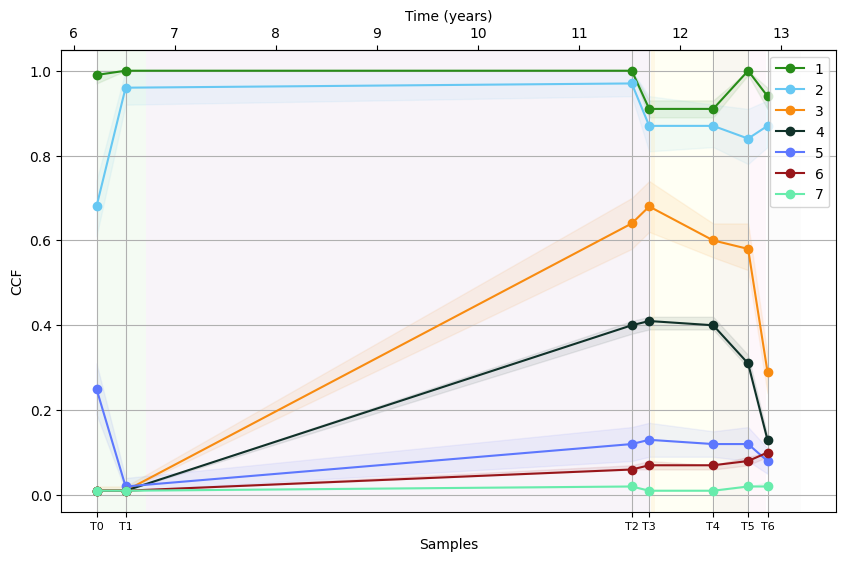

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_ccf(cluster_CCF_df,ax, times_sample )

In [14]:
def interpolate_abundance(abundance, mcmc, mode="interpolate_only"):
    """
    Parse abundance file and get abundance information and calculate interpolated abundance

    Args:
        cell_population_abundance file and mcmc_trace file
        mode: "interpolate_only" or "extrapolate"

    Returns:
        lists

    """

    cluster_map = {}

    # Get the cluster list from the mcmc file
    cluster_list = mcmc.Cluster_ID.unique().tolist()

    # Map the abundacne to each cluster in a dictionary
    for cluster_id in cluster_list:
        abundance['cluster'] = abundance['Cell_population'].str.split('_').str[-1].str[2:].astype(int)

        cluster_map[cluster_id] = abundance[abundance.cluster == cluster_id]

    ## To get abundance information from the cell_population_abundances.tsv
    cluster_abundance = {}
    for cluster_id, abundances in cluster_map.items():
        cluster_abundances = []
        ## iterate through the samples in the wbc file to make sure the order is correct
        for sample_name in sample_list:
            sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)
            cluster_abundances.append(sample_abundances / 100)
        cluster_abundance[cluster_id] = cluster_abundances

    ## To calculate interpolated abundance
    inter_abundance = {}
    for cluster_id, abundance in cluster_abundance.items():
        abundance_first = abundance[0]
        abundance_last = abundance[-1]
        if mode == "extrapolate":
            interpolate_func = interpolate.interp1d(times_sample, abundance, bounds_error=False,
                                                    fill_value=(abundance_first, abundance_last))
            abundance_interpolate = interpolate_func(times)

        if mode == "interpolate_only":
            interpolate_func = interpolate.interp1d(times_sample, abundance)

            abundance_interpolate = interpolate_func(times_interpolate)

        inter_abundance[cluster_id] = list(abundance_interpolate)

    return cluster_list, cluster_abundance, inter_abundance

In [15]:
cluster_list, cluster_abundance, inter_abundance = interpolate_abundance(abundance_df, mcmc_df)

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_78761/47543564.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)


In [16]:
cluster_abundance

{1: [0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 2: [0.67, 0.97, 0.27, 0.21, 0.27, 0.29, 0.61],
 3: [0.0, 0.0, 0.24, 0.26, 0.21, 0.26, 0.12],
 4: [0.01, 0.01, 0.4, 0.42, 0.4, 0.32, 0.14],
 5: [0.21, 0.02, 0.09, 0.0, 0.03, 0.13, 0.06]}

In [17]:
def calc_subclone(wbc, inter_abundance, cluster_list, mode = "default" , input_type = "default"):
    
    """
    Calculate subclone abundance from interpolated abundance

    Args:
        wbc and inter_abundance
        mode: "default" or "positive (ensure positivity after taking the log)"
        input type: "default" or "mcmc (contains values of all iterations)"
    Returns:
        dictionaries

    """
    
    subclone_population = {}
    log_subclone ={}
    log_subclone_raw ={}
    
    if input_type == "default":
        for cluster_id in cluster_list:
            subclone_population[cluster_id] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id])]
            if mode == "default":
                log_subclone[cluster_id] = [np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [np.log(item*1000) for item in subclone_population[cluster_id]] 

            if mode == "positive":
                log_subclone[cluster_id] = [0 if item <1 else np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population[cluster_id]]

    if input_type == "mcmc":
        for cluster_id in cluster_list:
         
            subclone_population_per_iter = {}
            log_subclone_per_iter = {}
            log_subclone_raw_per_iter = {}
            
            for iter_idx in range(250):
                
                subclone_population_per_iter[iter_idx] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id][iter_idx])]
                if mode == "default":
                    log_subclone_per_iter[iter_idx] = [np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [np.log(item*1000) for item in subclone_population_per_iter[iter_idx]] 

                if mode == "positive":
                    log_subclone_per_iter[iter_idx] = [0 if item <1 else np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population_per_iter[iter_idx]]

            subclone_population[cluster_id] = subclone_population_per_iter
            log_subclone[cluster_id] = log_subclone_per_iter
            log_subclone_raw[cluster_id] = log_subclone_raw_per_iter
                
    return subclone_population, log_subclone, log_subclone_raw

In [18]:
# calculate only at sample points
subclone_sample, log_subclone_sample, log_subclone_raw_sample = calc_subclone(wbc_sample, cluster_abundance, cluster_list, mode = "default")

In [19]:
def get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample):
    
    """
    Get cell abundance and interpolated cell abundance from all mcmc iterations

    Args:
        cluster_list, mcmc_df, sample_list
    Returns:
        a dictionary with key: cluster and value: 250 iterations of cell abundance

    """
    all_abundance = {}
    interpolated_all_abundance = {}
    for cluster in cluster_list:

        abundance_per_iter ={}
        inter_abundance_per_iter = {}
        for iter_idx in range(250):

            df_mcmc_iter_clust = mcmc_df[(mcmc_df.Iteration == iter_idx) & (mcmc_df.Cluster_ID == cluster) ]

            cluster_abundances = []
            ## iterate through the samples in the wbc file to make sure the order is correct
            for sample_name in sample_list:
                sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)
                cluster_abundances.append(sample_abundance / 100)

            abundance_per_iter[iter_idx] = cluster_abundances
            
            
        all_abundance[cluster] = abundance_per_iter
        
    return all_abundance

In [20]:
all_abundance = get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_78761/2664756645.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)


In [21]:
all_abundance[3]

{0: [0.02, 0.0, 0.3, 0.28, 0.16, 0.3, 0.14],
 1: [0.0, 0.0, 0.25, 0.27, 0.14, 0.27, 0.18],
 2: [0.0, 0.0, 0.27, 0.25, 0.2, 0.24, 0.17],
 3: [0.0, 0.0, 0.24, 0.28, 0.22, 0.28, 0.11],
 4: [0.0, 0.0, 0.2, 0.23, 0.19, 0.27, 0.2],
 5: [0.01, 0.01, 0.22, 0.19, 0.13, 0.23, 0.12],
 6: [0.0, 0.0, 0.23, 0.27, 0.17, 0.31, 0.11],
 7: [0.01, 0.0, 0.14, 0.32, 0.2, 0.27, 0.12],
 8: [0.0, 0.02, 0.25, 0.28, 0.2, 0.31, 0.12],
 9: [0.0, 0.01, 0.16, 0.31, 0.19, 0.22, 0.17],
 10: [0.01, 0.01, 0.26, 0.29, 0.21, 0.29, 0.11],
 11: [0.0, 0.0, 0.24, 0.34, 0.2, 0.26, 0.16],
 12: [0.01, 0.0, 0.24, 0.24, 0.23, 0.28, 0.12],
 13: [0.04, 0.0, 0.19, 0.27, 0.22, 0.21, 0.13],
 14: [0.0, 0.0, 0.21, 0.24, 0.18, 0.27, 0.19],
 15: [0.0, 0.01, 0.22, 0.32, 0.22, 0.27, 0.2],
 16: [0.0, 0.0, 0.26, 0.24, 0.19, 0.25, 0.2],
 17: [0.02, 0.0, 0.26, 0.21, 0.2, 0.25, 0.18],
 18: [0.0, 0.0, 0.2, 0.34, 0.21, 0.18, 0.12],
 19: [0.0, 0.0, 0.26, 0.27, 0.18, 0.3, 0.16],
 20: [0.01, 0.0, 0.24, 0.25, 0.15, 0.28, 0.16],
 21: [0.0, 0.01, 0.25, 

In [22]:
subclone_sample_mcmc, log_subclone_sample_mcmc, log_subclone_raw_sample_mcmc = calc_subclone(wbc_sample, all_abundance, cluster_list, mode = "default", input_type = "mcmc")

In [23]:
def slice_wbc(dfd_first, dfd_last, times, wbc, times_sample):
    '''
    select wbc between the two dfds 

    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd_last and time_ >=dfd_first]

    smallest_times_selected = min(times_selected)
    largest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)
    largest_index = times.index(largest_times_selected)

    wbc_selected = wbc[smallest_index: largest_index+ 1]

    return times_selected, wbc_selected

In [24]:
# Select the time period where exponential pattern is assumed 

exp_sample_start = 2
exp_sample_end = 3


In [25]:
times_sliced, wbc_sliced = slice_wbc(times_sample[exp_sample_start], times_sample[exp_sample_end], times, wbc, times_sample)

1 [  4.10166659 -53.38279482]
2 [  2.64625138 -28.71423675]
3 [  4.56522046 -50.9395489 ]
4 [  4.38427081 -48.34425066]
5 [-35.31546705 407.52768834]


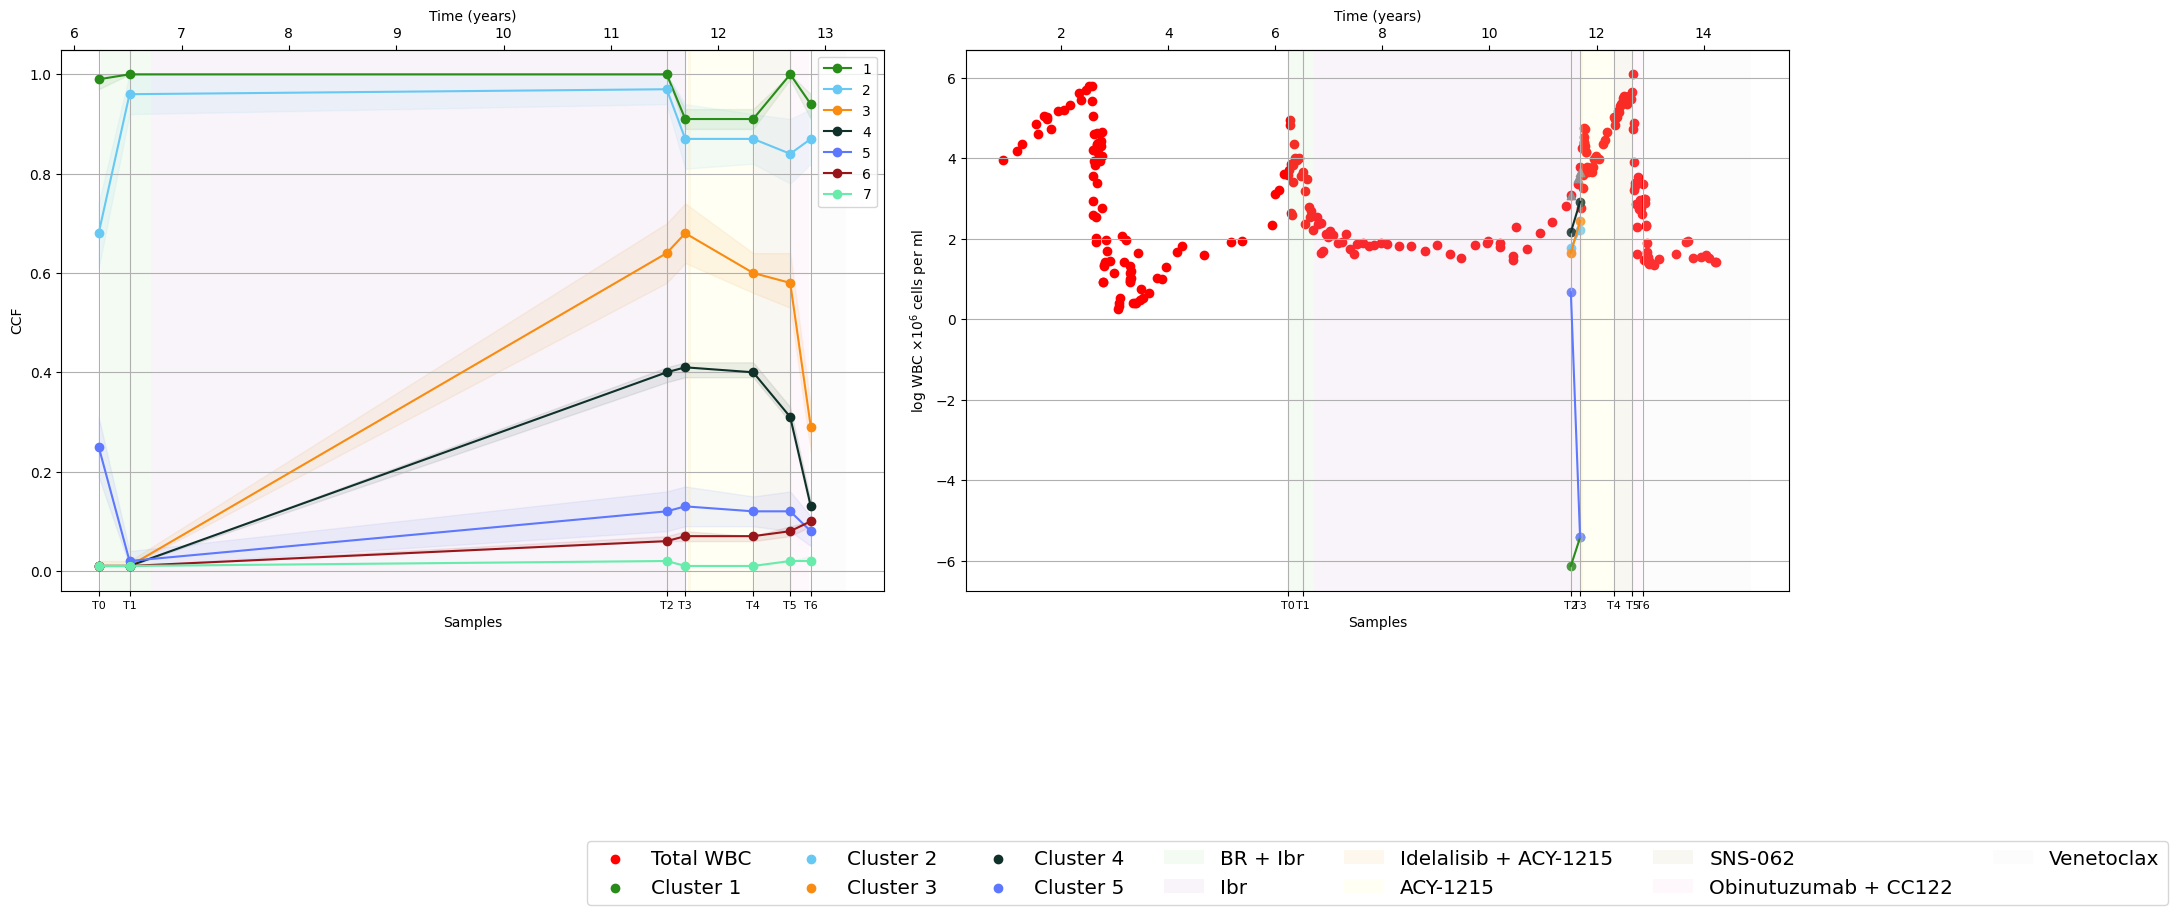

In [26]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')



    cluster_cell_population = {}
    for i in clusters:
        
        
        
         # Interpolate during treatment 

        exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
        exp_year = [ i/365 for i in np.array(exp_times)]
        exp_subclone = log_subclone_sample[i][exp_sample_start : exp_sample_end + 1 ]

        
        ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
        model = np.polyfit(exp_year, exp_subclone, 1)
        print(i, model)

        predict_x = times_sliced
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

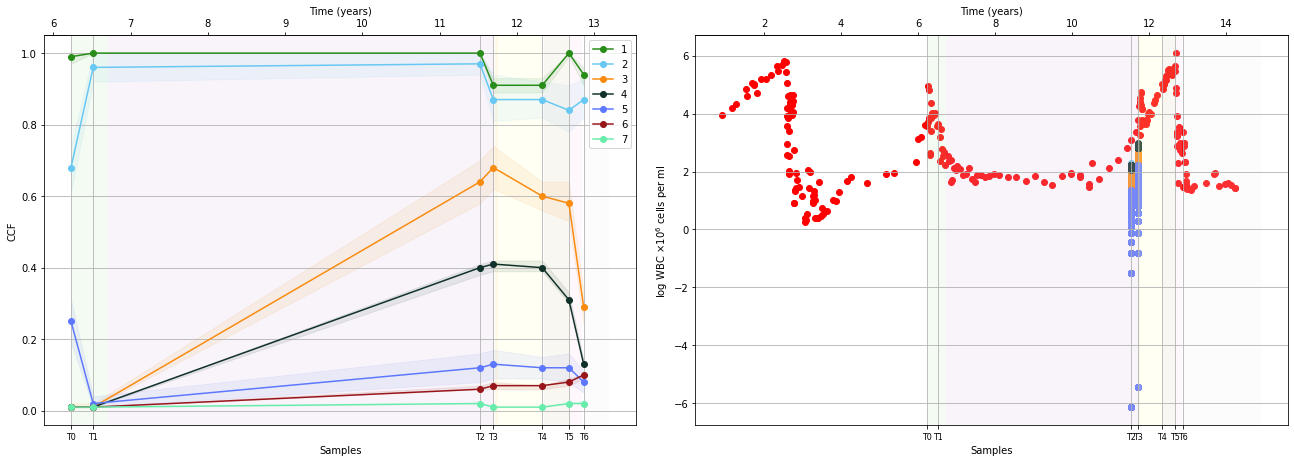

In [76]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
BTK_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in range(250):
        
         # Interpolate during treatment 

            exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
            exp_year = [ i/365 for i in np.array(exp_times)]
            exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


            ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

            model = np.polyfit(exp_year, exp_subclone, 1)
            
            if i ==3:
                
                BTK_rate_mcmc.append(model[0])
    
      

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5])
# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [77]:
lower_ci = np.percentile(BTK_rate_mcmc, 2.5, axis=0)
upper_ci = np.percentile(BTK_rate_mcmc, 97.5, axis=0)
mean = np.mean(BTK_rate_mcmc)

In [78]:
lower_ci, mean, upper_ci

(2.1908304134118195, 4.682887016583372, 7.52896505052238)

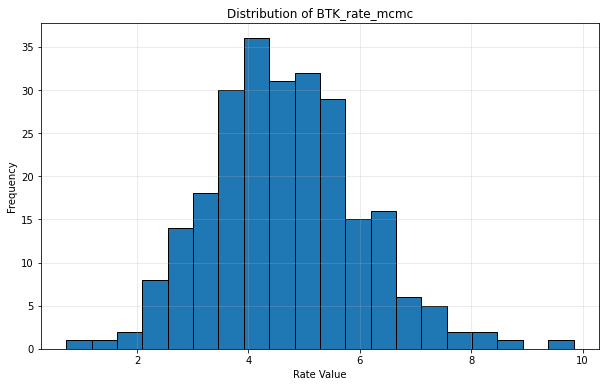

95% Confidence Interval: 4.68 (2.19, 7.53)


In [79]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(BTK_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of BTK_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")

In [47]:
from scipy.special import logsumexp 
from scipy.optimize import minimize
class MultiClusterLinearRegression:
    def __init__(self, n_clusters, y_weight =1 , logsumexp_weight = 1):
        self.n_clusters = n_clusters
        self.params = None
        self.y_weight = y_weight
        self.logsumexp_weight = logsumexp_weight
        

    def objective(self, params, X, y, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]


        # calculate predicted y values for all clusters 
        y_pred = np.outer(X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(y):
   
            if yi is not None:
                likelihood -= self.y_weight * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood -= self.logsumexp_weight *(lse - logsumexp(y_pred[i]))**2

        return -likelihood  # We minimize negative log-likelihood



    def fit(self, X, y, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (X,y, logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 


        y_model = model.predict(predict_year)



    def predict(self, X):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(X, slopes) + intercepts
    


In [45]:
n_clusters = 5
X = times_sliced
predict_year = [ i/365 for i in np.array(X)]
def dict_to_2d_array(dictionary):
    values = list(dictionary.values())
    array = np.array(values)
    return array.T[-3:]


def create_y(n, last_three_rows):
    # Create an array of shape (n, 4) filled with None
    arr = [None] *n 
    
    # Fill the last three rows with the provided values
    arr[-3:] = last_three_rows

    return arr
y = create_y(len(X), dict_to_2d_array(log_subclone_sample))

logsumexp_points = np.log(wbc_sliced)

In [49]:
model_v2 = MultiClusterLinearRegression(5)
model_v2.fit(predict_year, y, logsumexp_points)

1 [-0.03980815 -5.30726368]
2 [-0.3166039  5.6795118]
3 [  1.49579242 -15.30867038]
4 [ 0.68717094 -5.42716176]
5 [-0.4468831   2.76228517]


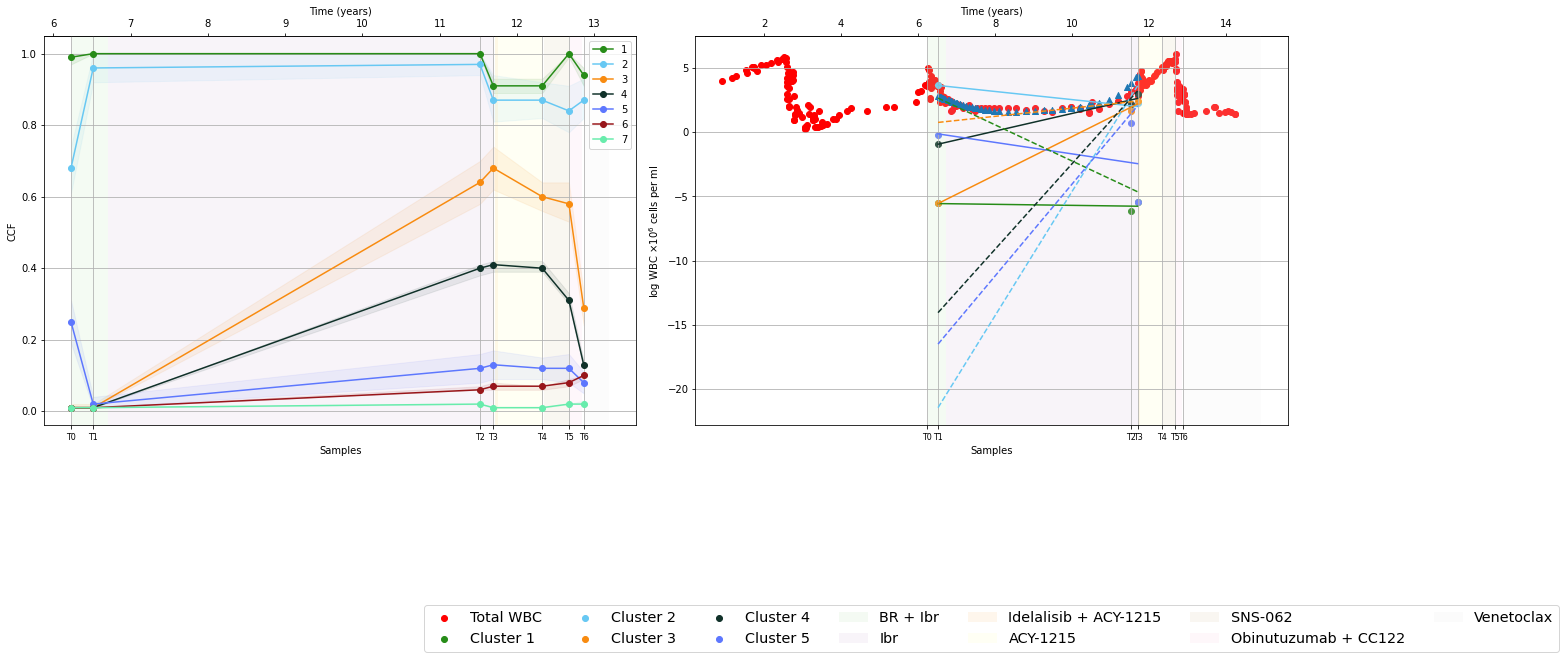

In [53]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')



    cluster_cell_population = {}
    for i in clusters:
        
        
        
         # Interpolate during treatment 

        exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
        exp_year = [ i/365 for i in np.array(exp_times)]
        exp_subclone = log_subclone_sample[i][exp_sample_start : exp_sample_end + 1 ]

        
        ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
        model = np.polyfit(exp_year, exp_subclone, 1)
        print(i, model)

        predict_x = times_sliced
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
#     plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

for i in [1,2,3,4,5]:

    ax2.plot(predict_year,model_v2.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
    
    
logsumexp_points_model = [logsumexp(yi) for yi in model_v2.predict(predict_year)]
ax2.scatter(predict_year, logsumexp_points_model,marker='^')

In [54]:
def restructure_dict(original_dict):
    new_dict = {}
    
    # Iterate through each cluster
    for cluster, iterations in original_dict.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in new_dict:
                new_dict[iteration] = {}
            # Add the cluster and its value to this iteration
            new_dict[iteration][cluster] = value
    
    return new_dict

In [56]:
def dict_to_2d_array_mcmc(dictionary_mcmc, iter):

    
    values = list(dictionary_mcmc[iter].values())
    array = np.array(values)
    return array.T[-3:]

In [55]:
log_subclone_sample_iter = restructure_dict(log_subclone_sample_mcmc)

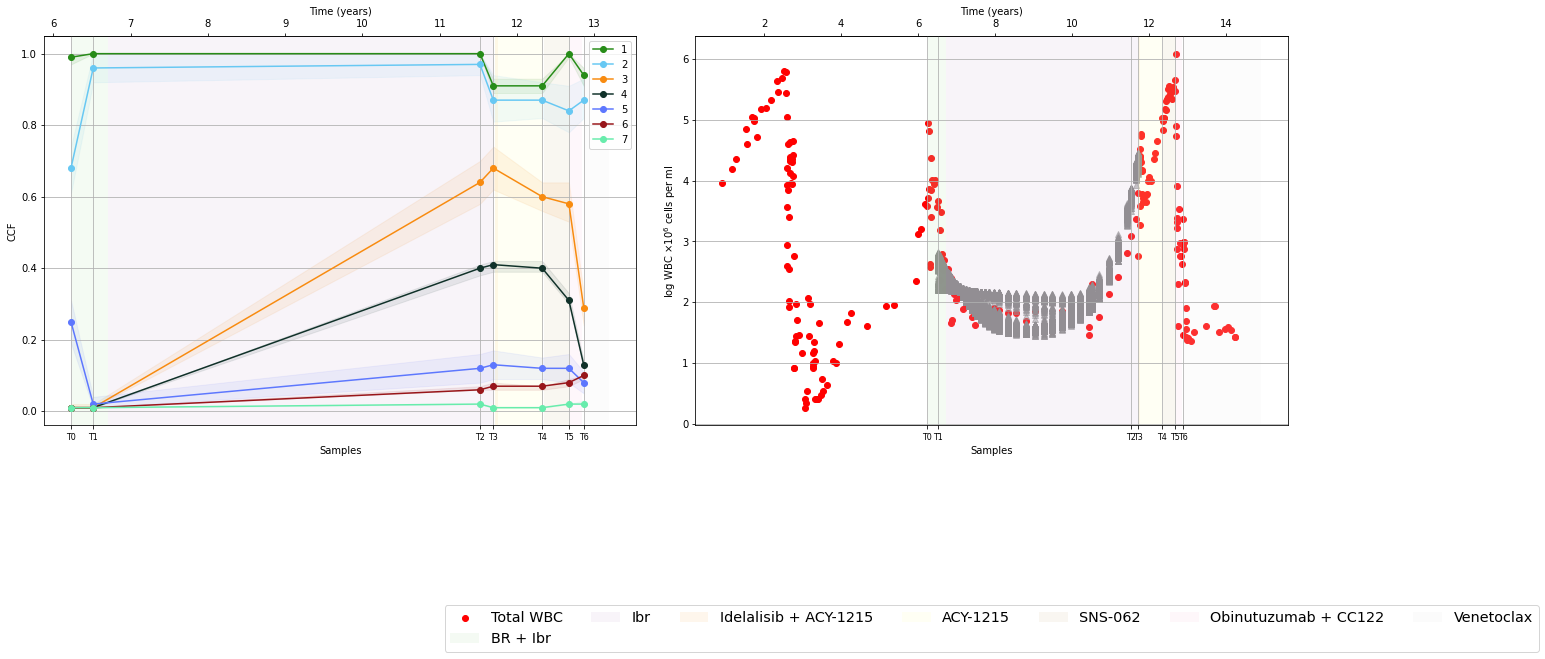

In [60]:
fig,(ax1, ax2,) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, cluster):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters =5,y_weight=1.0, logsumexp_weight=1.0)

        y = create_y(len(X), dict_to_2d_array_mcmc(log_subclone_sample_iter, iter_idx))

        
        model.fit(predict_year, y, logsumexp_points )

        logsumexp_points_model = [logsumexp(yi) for yi in model.predict(predict_year)]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax2.scatter(predict_year, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, 1, )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




# ax2.plot(predict_year,model.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(predict_year, logsumexp_points_model,marker='^')

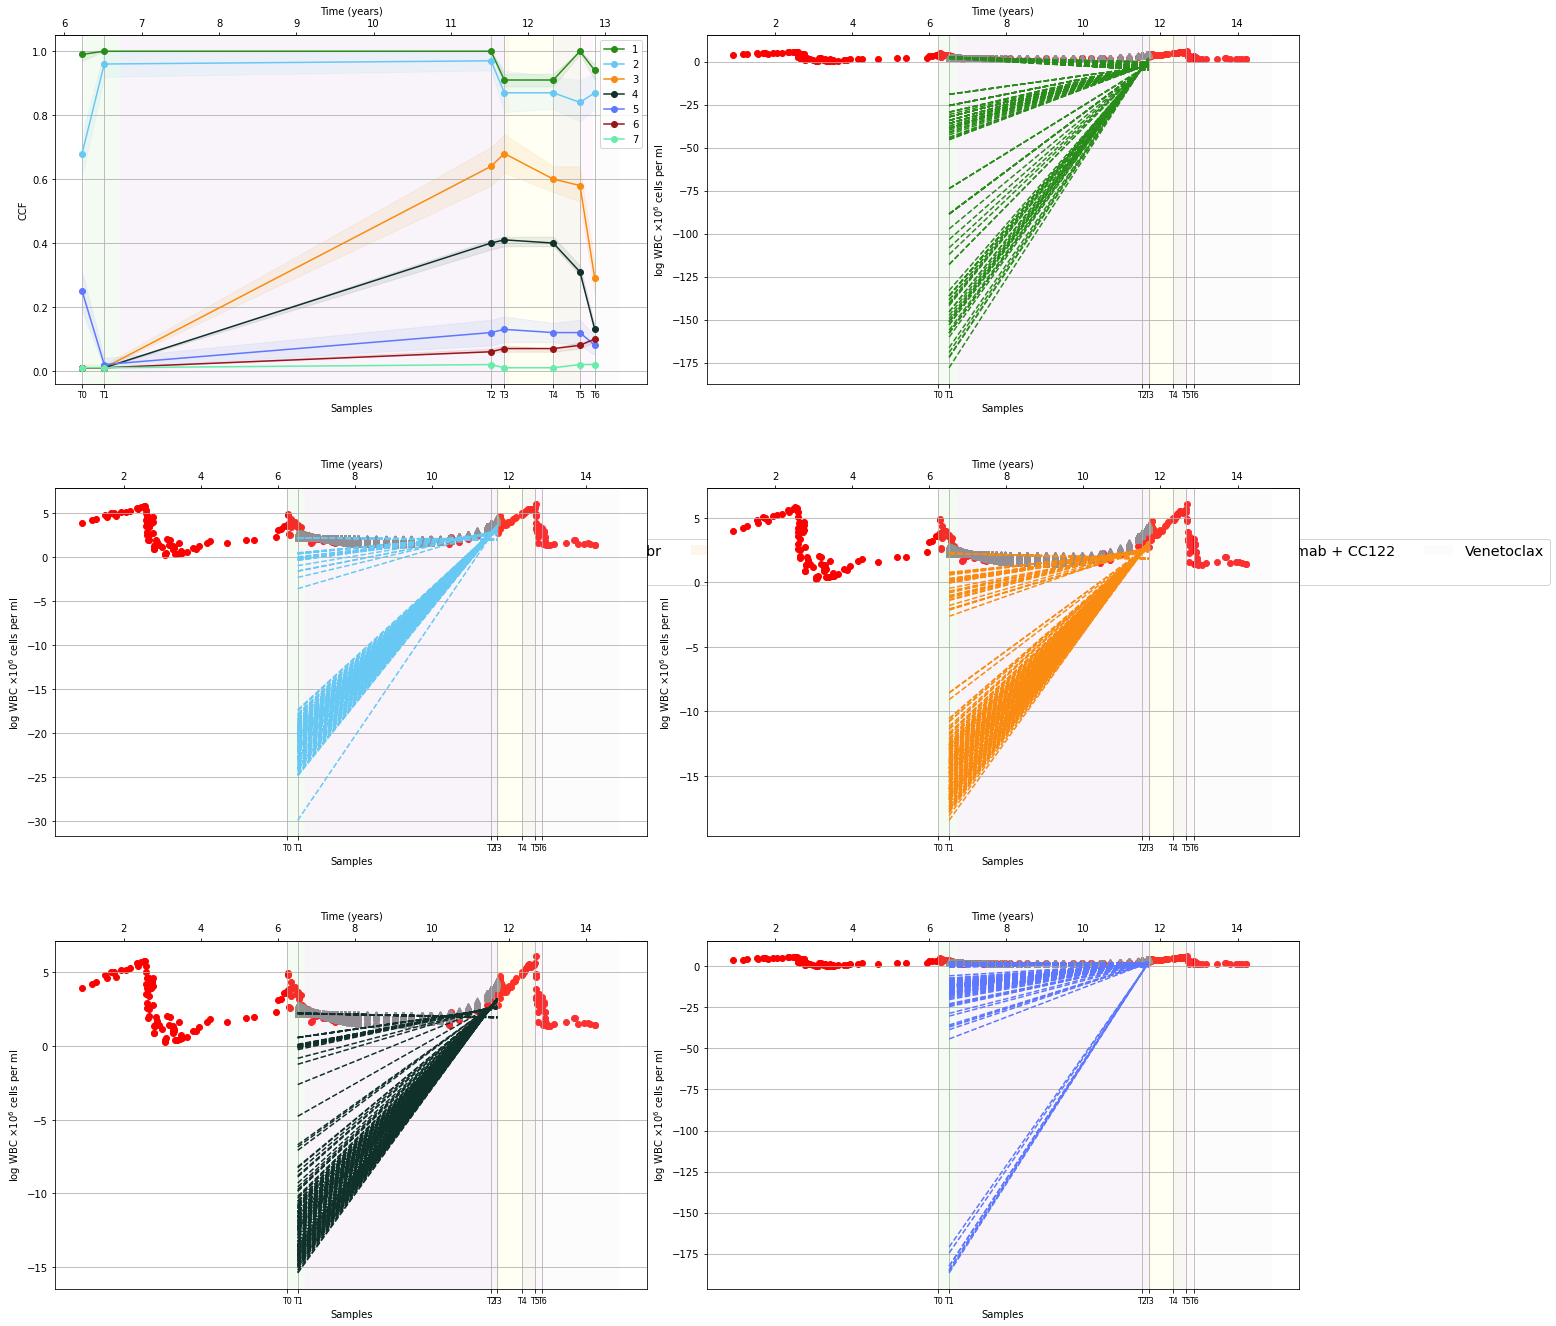

In [64]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, cluster):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters =5,y_weight=1.0, logsumexp_weight=1.0)

        y = create_y(len(X), dict_to_2d_array_mcmc(log_subclone_sample_iter, iter_idx))

        
        model.fit(predict_year, y, logsumexp_points )
        

        ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict(predict_year)]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(predict_year, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, 1, )
plot_sub(ax3, 2, )
plot_sub(ax4, 3, )
plot_sub(ax5, 4, )
plot_sub(ax6, 5, )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




# ax2.plot(predict_year,model.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(predict_year, logsumexp_points_model,marker='^')

In [65]:
print("Slopes:", model.params[n_clusters:])

Slopes: [-1.40682616  4.83363418  0.3197196   3.32880127  3.57542021]


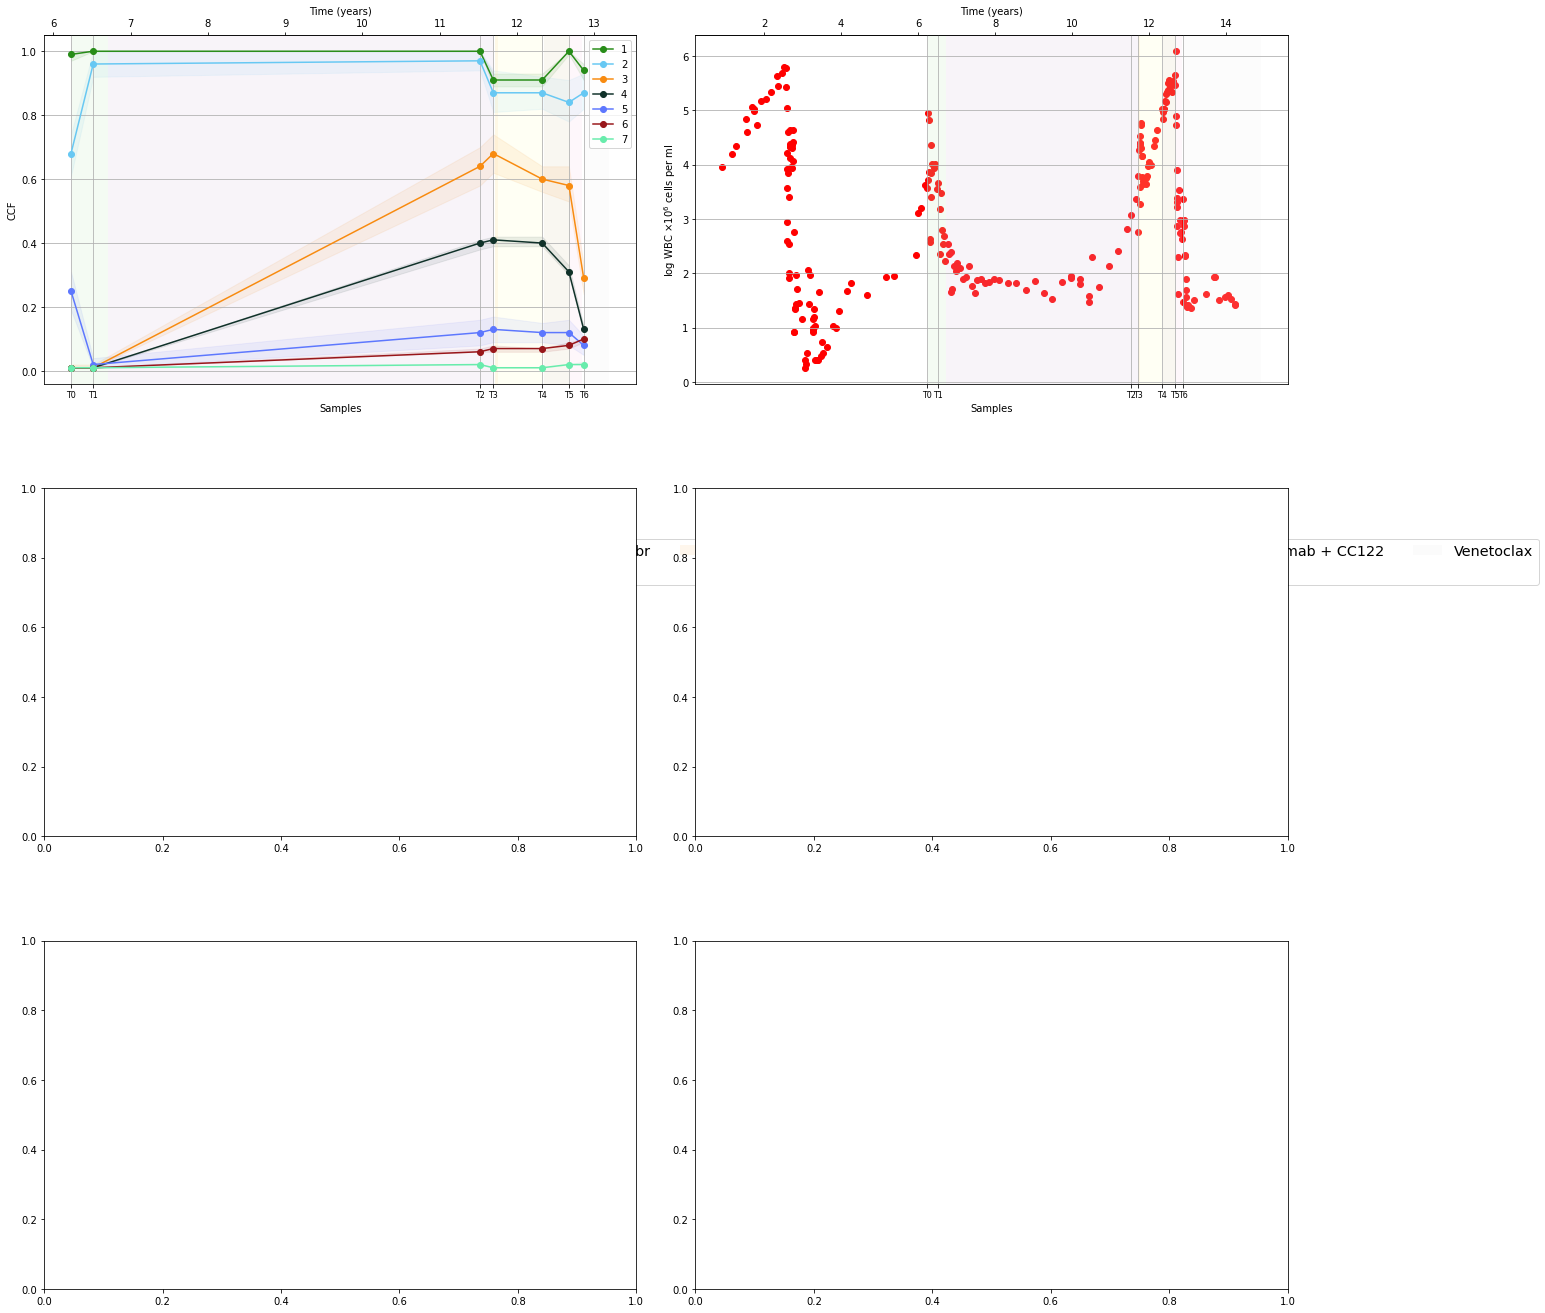

In [67]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

rates={}
def plot_sub(ax, cluster):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters =5,y_weight=1.0, logsumexp_weight=1.0)

        y = create_y(len(X), dict_to_2d_array_mcmc(log_subclone_sample_iter, iter_idx))

        
        model.fit(predict_year, y, logsumexp_points )
        rates[iter_idx] = model.params[n_clusters:]

#         ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
        


#         logsumexp_points_model = [logsumexp(yi) for yi in model.predict(predict_year)]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
#         ax.scatter(predict_year, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, 1, )
# plot_sub(ax3, 2, )
# plot_sub(ax4, 3, )
# plot_sub(ax5, 4, )
# plot_sub(ax6, 5, )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




# ax2.plot(predict_year,model.predict(predict_year)[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(predict_year, logsumexp_points_model,marker='^')

In [68]:
rates

{0: array([-0.98851393,  4.32152075,  3.35070609,  2.8521587 ,  0.23279721]),
 1: array([-1.39016399,  4.67213008,  3.74953358,  2.98617341,  0.19363303]),
 2: array([13.86288012,  4.38657716,  3.43425769, -0.05132522, 36.44111932]),
 3: array([ 5.78794768,  5.44498338,  2.86135995,  1.11831572, -0.46280585]),
 4: array([-1.06159204,  0.58295983,  4.03178021,  3.4270229 ,  2.72588911]),
 5: array([ 4.45287038,  4.96911356,  3.14524026,  1.06146388, -0.47861873]),
 6: array([28.73496634,  4.25167664,  2.98087275,  2.87418299, -0.16836649]),
 7: array([-1.4072611 ,  5.31516361,  0.31651741,  3.30056157,  1.95858552]),
 8: array([-0.90145693,  4.44739924,  3.11041931,  2.93627064,  0.2878317 ]),
 9: array([-1.37737277,  4.89090797,  3.10795332,  2.75666093,  0.11814419]),
 10: array([-0.97344253,  4.94437874,  2.91443073,  1.4891071 , -0.03215869]),
 11: array([-1.41266557,  5.08178363,  3.71050357,  0.37823145,  3.10811572]),
 12: array([-0.97179666,  4.61899713,  2.88782572,  2.77016865

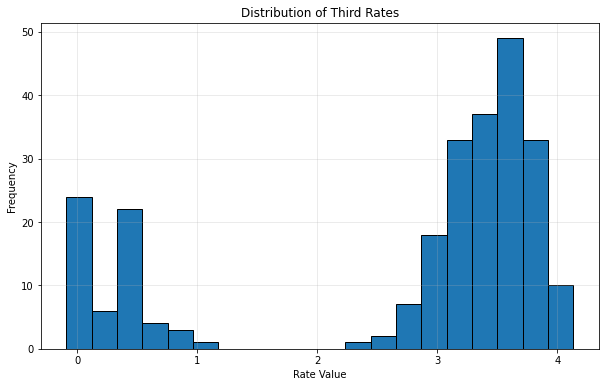

Mean: 2.68
Min: -0.09
Max: 4.14


In [69]:
third_rates = [r[2] for r in rates.values()]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(third_rates, bins=20, edgecolor='black')
plt.title('Distribution of Third Rates')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower:.2f}, {upper:.2f})")